In [1]:
from google.colab import drive       
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/Kaggle/FaceMask.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [3]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
data_dir = './Face Mask Dataset'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/Train")
print(classes)

['Validation', 'Train', 'Test']
['WithMask', 'WithoutMask']


In [5]:
train_ds = ImageFolder(data_dir+'/Train')
val_ds = ImageFolder(data_dir+'/Validation')
test_ds = ImageFolder(data_dir+'/Test')

In [6]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

10000
800
992


In [7]:
train_ds.classes

['WithMask', 'WithoutMask']

Label:  WithMask
Label:  WithMask
Label:  WithMask
Label:  WithMask
Label:  WithMask
Label:  WithMask
Label:  WithMask
Label:  WithMask
Label:  WithMask
Label:  WithMask
example
Label:  WithMask


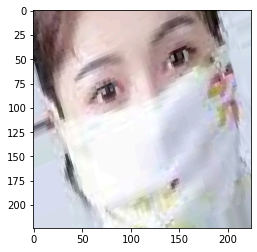

In [38]:
for i in range(0,10):
  image, label = train_ds[i]
  print('Label: ', classes[label])


print('example')
image, label = train_ds[1024]
plt.imshow(image.permute(1,2,0))
print('Label: ', classes[label])

In [9]:
train_tfms= tt.Compose([tt.Resize(224),tt.ToTensor() ])
val_tfms= tt.Compose([tt.Resize(224),tt.ToTensor()])
test_tfms= tt.Compose([tt.Resize(224),tt.ToTensor()])
train_ds = ImageFolder(data_dir+'/Train', train_tfms)
val_ds = ImageFolder(data_dir+'/Validation', val_tfms)
test_ds = ImageFolder(data_dir+'/Test', test_tfms)

In [10]:
batch_size=128
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [11]:
img_tensor, label = train_ds[100]
print(img_tensor.shape, label)

torch.Size([3, 224, 224]) 0


In [12]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [13]:
device = get_default_device()
device

device(type='cuda')

In [14]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [15]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [16]:
i_size=3*224*224

In [17]:
class Dnn(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [18]:
class Net(Dnn):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(i_size,128)
        self.linear2 = nn.Linear(128,256)
        self.linear3 = nn.Linear(256,256)
        self.linear4 = nn.Linear(256,256)
        self.linear5 = nn.Linear(256,2)

    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        out = self.linear1(out)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        out = F.relu(out)
        out = self.linear4(out)
        out = F.relu(out)
        out = self.linear5(out)
        out = F.relu(out)
        return out

In [19]:
net=Net()
print(net)

Net(
  (linear1): Linear(in_features=150528, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=256, bias=True)
  (linear4): Linear(in_features=256, out_features=256, bias=True)
  (linear5): Linear(in_features=256, out_features=2, bias=True)
)


In [20]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [21]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [22]:
model = to_device(net, device)

In [23]:
history = [evaluate(model, val_loader)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.5357142686843872, 'val_loss': 0.6931412816047668}]

In [24]:
history += fit(10,0.001, model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 0.6803, val_acc: 0.7924
Epoch [1], val_loss: 0.6617, val_acc: 0.8237
Epoch [2], val_loss: 0.6349, val_acc: 0.8627
Epoch [3], val_loss: 0.6010, val_acc: 0.8538
Epoch [4], val_loss: 0.5568, val_acc: 0.8482
Epoch [5], val_loss: 0.5059, val_acc: 0.8471
Epoch [6], val_loss: 0.4765, val_acc: 0.8069
Epoch [7], val_loss: 0.3898, val_acc: 0.8739
Epoch [8], val_loss: 0.3522, val_acc: 0.8783
Epoch [9], val_loss: 0.3199, val_acc: 0.8806


In [25]:
evaluate(model, test_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.892578125, 'val_loss': 0.3157638907432556}

In [26]:
def predict_image(img, model):
    xb = img.unsqueeze(0)  #https://stackoverflow.com/questions/57237352/what-does-unsqueeze-do-in-pytorch
    xb = xb.to(device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

In [31]:
#Wrong prediction
#img, label = test_ds[420]
#plt.imshow(img.permute(1,2,0))
#print('Label:', classes[label], ', Predicted:', classes[predict_image(img, model)])


tot = 0;
correct = 0;
for i in range(len(test_ds)):
  img, label=test_ds[i]
  if(classes[label]==classes[predict_image(img,model)]):
    correct+=1
  tot+=1

print(f"Accuracy {round(correct/tot,3)}")

Accuracy 0.89


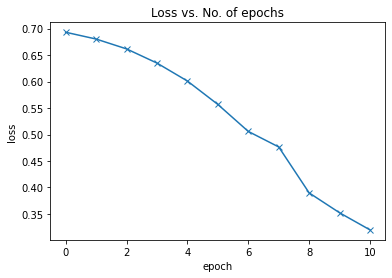

In [32]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

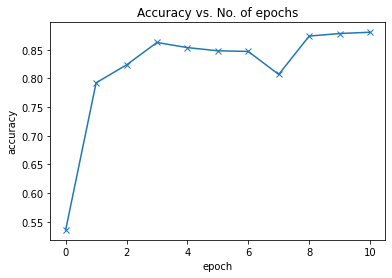

In [33]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');